## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string

### 1. Reading dataset and initial pre-processing

In [3]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [4]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

print(len(original_data))
print(len(train_data))

24000
23998


In [5]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

6000


In [6]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [7]:
train_data['title']

0                             “Horrible experience”
1                                       “Stay Away”
2                      “Great location and service”
3                “I will never go back here again!”
4        “Ripped off our VISA card after departure”
                            ...                    
23993            “pleasant stay with good location”
23994     “Hit or miss, some things need attention”
23995                              “Good breakfast”
23996                    “Deserves a higher rating”
23997                        “Clean & comfortable!”
Name: title, Length: 23998, dtype: object

In [8]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [9]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [10]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [11]:
train_data['clean_text'][0]

'First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY We thought by paying more we would get a good deal well this hotel is not the case 400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service Great time in San Diego but a nightmare of a hotel Dont ever write reviews but this one was called for if you can avoid this hotel do it Being a military family and moving from state to state we know

### 2. Exploratory Data Analysis (EDA)

In [12]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [13]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience,First of all we got there and they didnt have ...
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away,Found Racist graffiti in the room Request to c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...


In [14]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [15]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 152.347 words 
Longest review: 2239 words


In [16]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review review: {max_title_length} words")

Shortest review title: 0 words 
Average length of review title: 4.822 words 
Longest review review: 26 words


In [17]:
row_data = train_data.loc[train_data['clean_title'] == '']
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
2168,"{'service': 1.0, 'cleanliness': 5.0, 'overall'...","“!""”",We stayed in the W in Dallas twice. The first ...,"{'username': 'Chach63', 'num_cities': 15, 'num...",October 2011,600113,3,2012-07-06,133598143,False,,We stayed in the W in Dallas twice The first t...


In [18]:
print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

original title: “!"”,
cleaned title: '' 


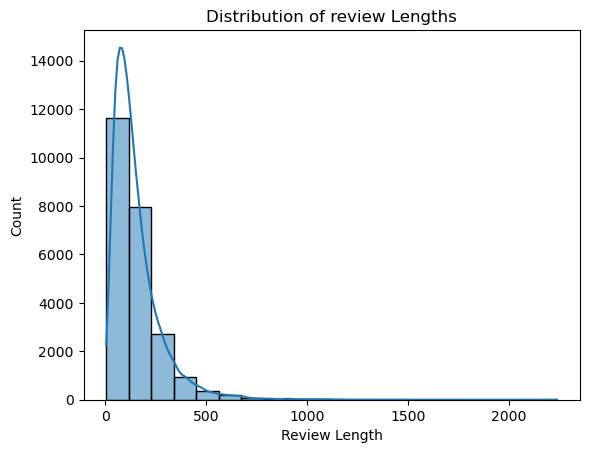

In [19]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

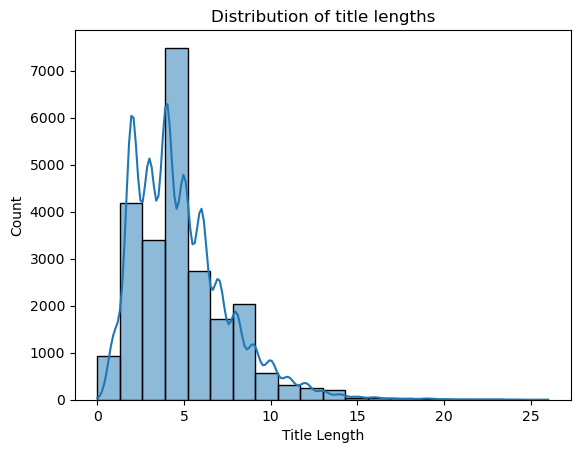

In [20]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

[(5, 9823), (4, 7720), (3, 3287), (2, 1611), (1, 1557)]


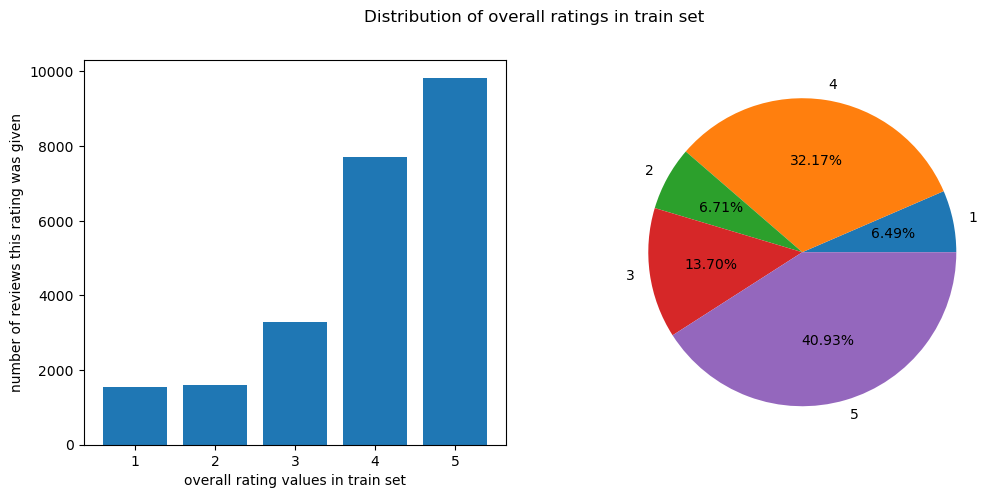

In [21]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

[(5, 2509), (4, 1888), (3, 828), (2, 408), (1, 367)]


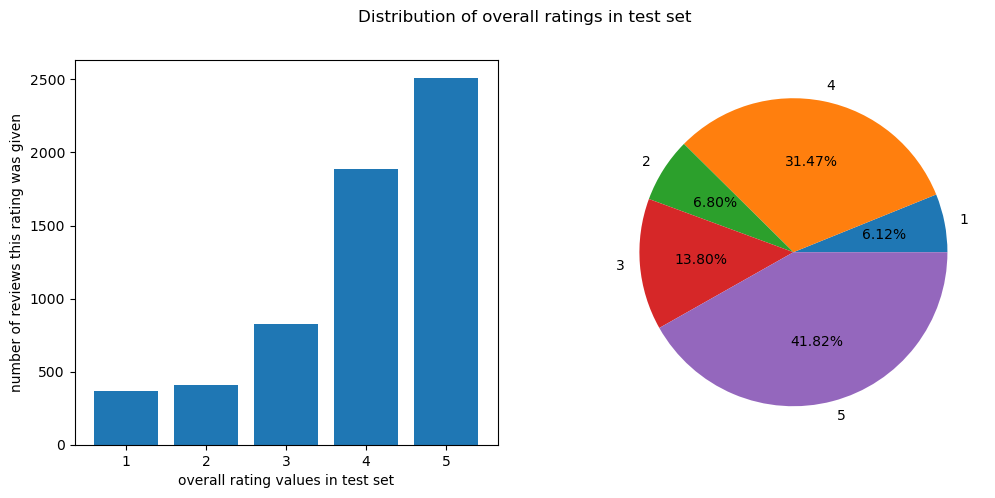

In [22]:
overall_ratings_plot(test_data, 'test')

In [23]:
def average_ratings(data):
    ratings = defaultdict(list)
    for i in range(len(data)):
        rat = train_data['ratings'][i]
        for n in rat:
            ratings[n].append(rat[n])
    
    avg_metrics = defaultdict(int)
    for n in ratings:
        avg_metrics[n] = np.round(np.array(ratings[n]).mean(),3)
    
    return avg_metrics

averaged_ratings_of_reviews = average_ratings(train_data)

for quality, rating in averaged_ratings_of_reviews.items():
    print(f'{quality}: {rating}')


service: 4.102
cleanliness: 4.23
overall: 3.943
value: 3.918
location: 4.413
sleep_quality: 4.146
rooms: 3.943
check_in_front_desk: 3.945
business_service_(e_g_internet_access): 3.662


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'service'),
  Text(1, 0, 'cleanliness'),
  Text(2, 0, 'overall'),
  Text(3, 0, 'value'),
  Text(4, 0, 'location'),
  Text(5, 0, 'sleep_quality'),
  Text(6, 0, 'rooms'),
  Text(7, 0, 'check_in_front_desk'),
  Text(8, 0, 'business_service_(e_g_internet_access)')])

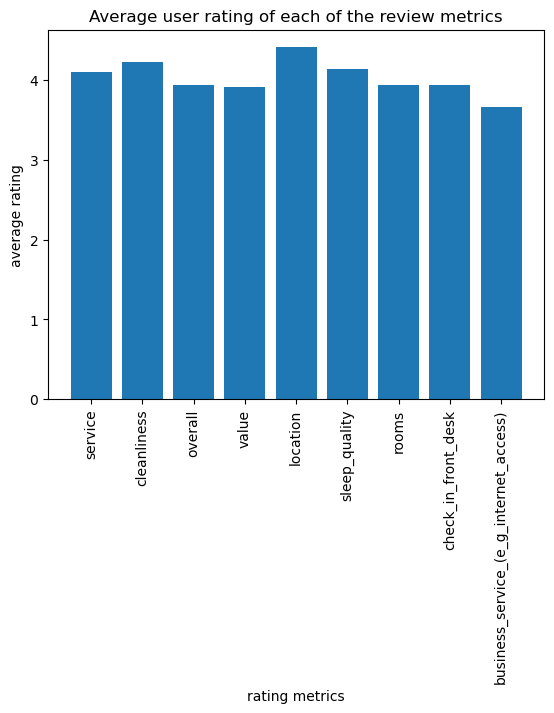

In [24]:
metric, value = zip(*averaged_ratings_of_reviews.items())
plt.bar(metric, value)
plt.xlabel('rating metrics')
plt.ylabel("average rating")
plt.title("Average user rating of each of the review metrics")
plt.xticks(rotation="vertical")

In [25]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 62493
most frequent words use in reviews: [('the', 192545), ('and', 127800), ('a', 103768), ('to', 93843), ('was', 80158), ('I', 59749), ('in', 57570), ('of', 50150), ('The', 47904), ('is', 46002)]


In [26]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 62488


[('the', 192545),
 ('and', 127800),
 ('a', 103768),
 ('to', 93843),
 ('was', 80158),
 ('I', 59749),
 ('in', 57570),
 ('of', 50150),
 ('The', 47904),
 ('is', 46002)]

In [27]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('hotel', 39292),
 ('room', 34699),
 ('stay', 16071),
 ('great', 14181),
 ('staff', 13928),
 ('would', 12190),
 ('rooms', 11191),
 ('nice', 10594),
 ('good', 10362),
 ('location', 10168)]

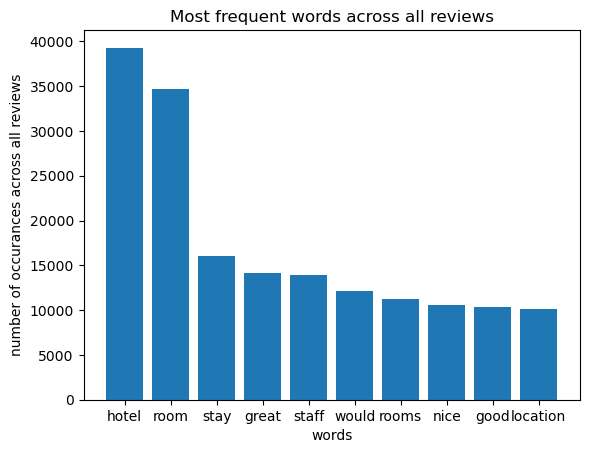

In [28]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

In [29]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['clean_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            if rating >= 2.5:
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('hotel', 33377),
 ('room', 27764),
 ('stay', 13738),
 ('great', 13559),
 ('staff', 12504),
 ('nice', 9749),
 ('would', 9737),
 ('location', 9335),
 ('good', 9330),
 ('rooms', 9315)]

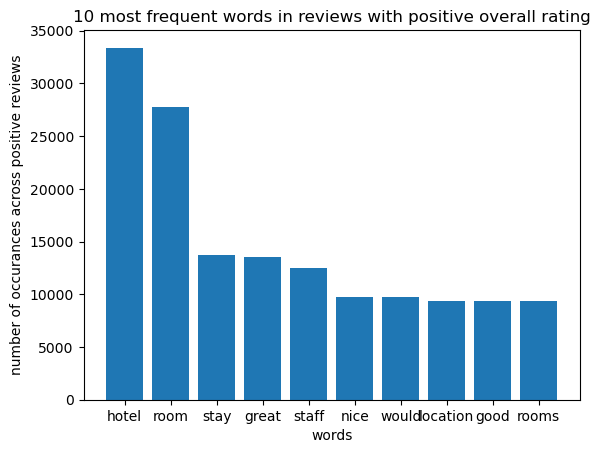

In [30]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [31]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 6935),
 ('hotel', 5915),
 ('would', 2453),
 ('stay', 2333),
 ('one', 1967),
 ('night', 1920),
 ('rooms', 1876),
 ('us', 1692),
 ('desk', 1629),
 ('get', 1557)]

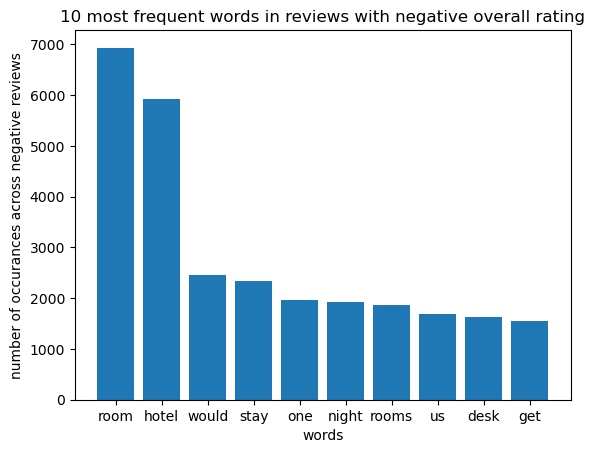

In [32]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

In [33]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
The room was: 2943
the front desk: 2927
in the room: 2192
of the hotel: 2064
The hotel is: 2030
stay here again: 1696
stayed at the: 1606
at this hotel: 1601
the room was: 1563
one of the: 1483


Not very useful. What if we look at the most common tri grams for both "positive" and negative reviews?


In [34]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2657
the front desk: 2047
The hotel is: 1894
of the hotel: 1777
in the room: 1680
stay here again: 1566
stayed at the: 1447
at this hotel: 1315
the room was: 1297
and it was: 1279


Most common 3-grams for negative rating reviews:
the front desk: 880
in the room: 512
of the hotel: 287
The room was: 286
at this hotel: 286
I had to: 267
the room was: 266
to the front: 223
we had to: 213
one of the: 209


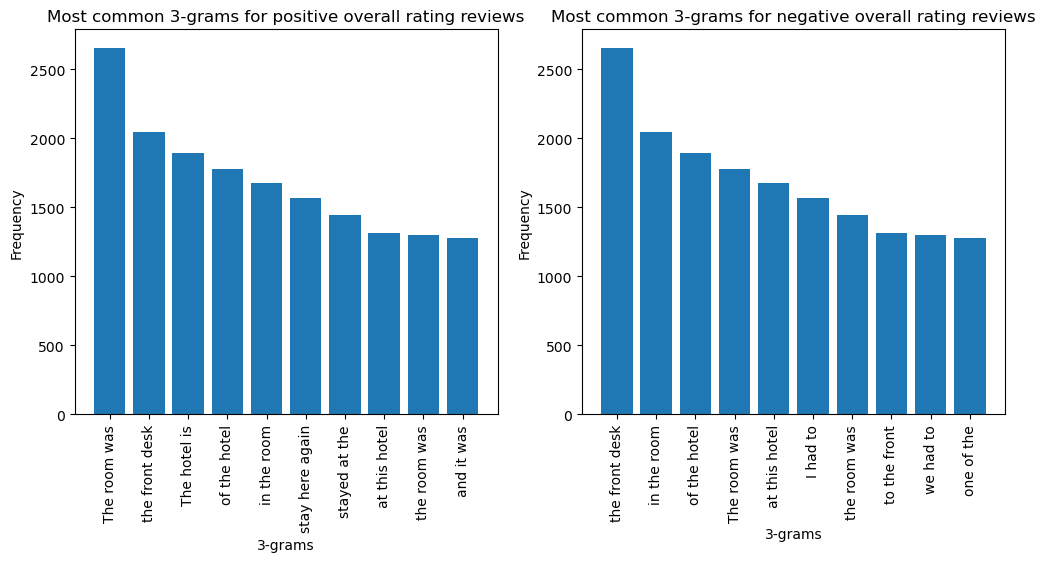

In [35]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

In [36]:
titles = train_data['clean_title']

title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('the', 3191), ('a', 3068), ('and', 2669), ('stay', 2616), ('in', 2120), ('good', 2096), ('for', 1984)]


In [37]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('stay', 2616), ('good', 2096), ('nice', 1662), ('service', 1402), ('staff', 1118), ('excellent', 1081), ('place', 1079)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

In [57]:
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [58]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        first of all we got there and they didnt have ...
1        found racist graffiti in the room request to c...
2        close to union squar hotel is a bit of a maze ...
3        i had a bad vibe about thi place from the mome...
4        after we receiv our final bill and left the em...
                               ...                        
23993    we stay just one night here when visit our son...
23994    spent two night here with spous in conjunct wi...
23995    the room wa fairli larg pretti quiet the bed w...
23996    great start to our stay when we were check in ...
23997    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 23998, dtype: object

In [59]:
import spacy

nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

0        first of all we get there and they do not have...
1        find racist graffiti in the room request to ch...
2        close to union square hotel be a bit of a maze...
3        I have a bad vibe about this place from the mo...
4        after we receive our final bill and leave the ...
                               ...                        
23993    we stay just one night here when visit our son...
23994    spend two night here with spouse in conjunctio...
23995    the room be fairly large pretty quiet the bed ...
23996    great start to our stay when we be check in 2h...
23997    great room comfortable bed food be good the lo...
Name: lemmatized_text, Length: 23998, dtype: object

In [60]:
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        1
1        1
2        4
3        2
4        1
        ..
23993    4
23994    3
23995    5
23996    4
23997    5
Name: overall, Length: 23998, dtype: int64

In [61]:
lem_train_data = train_data[['overall', 'clean_title','lemmatized_text']]
stem_train_data =  train_data[['overall', 'clean_title','stemmed_text']]

In [62]:
a1 = stem_train_data['stemmed_text'][4].split()
a2 = lem_train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
received      | receiv       | receive     
left          | left         | leave       
empire        | empir        | empire      
another       | anoth        | another     
charge        | charg        | charge      
accounting    | account      | accounting  
sent          | sent         | send        
justification | justif       | justification
response      | respons      | response    
company       | compani      | company     


In [63]:
lem_train_data

,overall,clean_title,lemmatized_text
0,1,horrible experience,first of all we get there and they do not have...
1,1,stay away,find racist graffiti in the room request to ch...
2,4,great location and service,close to union square hotel be a bit of a maze...
3,2,i will never go back here again,I have a bad vibe about this place from the mo...
4,1,ripped off our visa card after departure,after we receive our final bill and leave the ...
...,...,...,...
23993,4,pleasant stay with good location,we stay just one night here when visit our son...
23994,3,hit or miss some things need attention,spend two night here with spouse in conjunctio...
23995,5,good breakfast,the room be fairly large pretty quiet the bed ...
23996,4,deserves a higher rating,great start to our stay when we be check in 2h...


In [74]:
lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['clean_title'] + ' ' + lem_train_data['lemmatized_text']

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_absolute_error, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(lem_train_data["lemmatized_text"], lem_train_data["overall"], test_size=0.3, random_state=42)
print(len(X_train), len(X_test))

16798 7200


In [80]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Multinomial Naive Bayes:
Accuracy: 0.6177777777777778
F1 score: 0.5899597846487468
Mean Absolute Error: 0.4656
              precision    recall  f1-score   support

           1       0.71      0.61      0.66       455
           2       0.44      0.01      0.02       500
           3       0.44      0.33      0.38       989
           4       0.54      0.62      0.57      2337
           5       0.71      0.82      0.76      2919

    accuracy                           0.62      7200
   macro avg       0.57      0.48      0.48      7200
weighted avg       0.60      0.62      0.59      7200



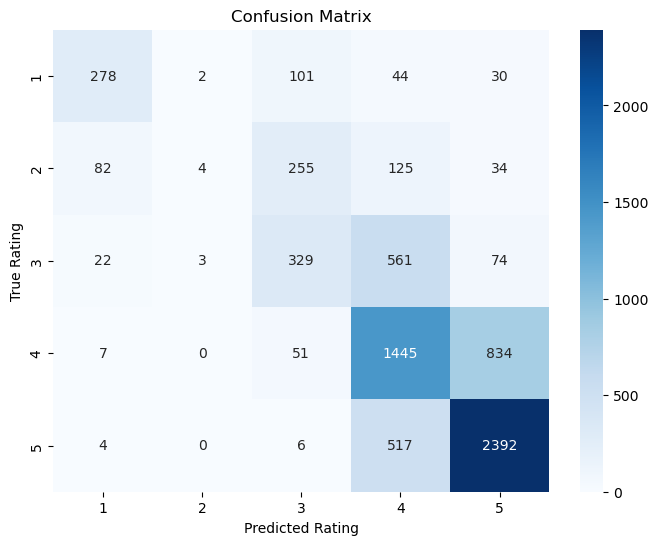

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_mnb)
acc = accuracy_score(y_test, y_pred_mnb)
weighted_f1 = f1_score(y_test, y_pred_mnb, average='weighted')

print("Multinomial Naive Bayes:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_mnb))

con_mat = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


SVM:
Accuracy: 0.6430555555555556
F1 score: 0.6372975483549013
Mean Absolute Error: 0.3925
              precision    recall  f1-score   support

           1       0.67      0.70      0.68       455
           2       0.40      0.27      0.32       500
           3       0.51      0.49      0.50       989
           4       0.59      0.59      0.59      2337
           5       0.74      0.79      0.77      2919

    accuracy                           0.64      7200
   macro avg       0.58      0.57      0.57      7200
weighted avg       0.63      0.64      0.64      7200



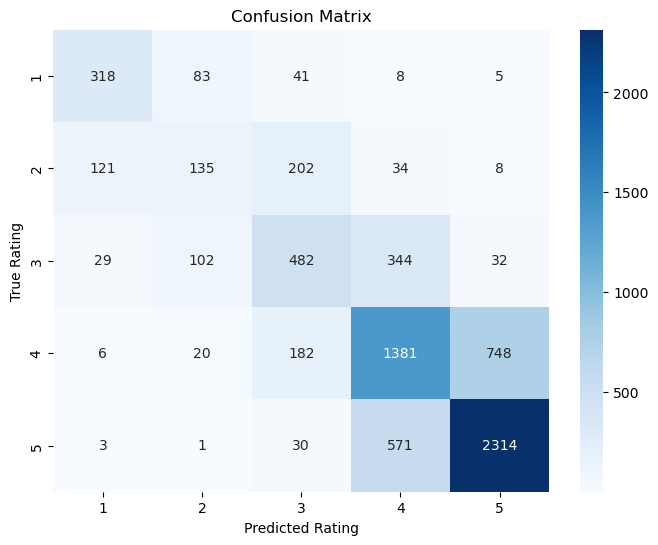

In [82]:
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


### 4. Experiment with VADER sentiment lexicon

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix